# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score

#Visualization
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from sklearn import random_projection

import datetime

In [2]:
dtype_dict = {
    'ProductFamily_ID':'category',
    'ProductCategory_ID':'category',
    'ProductBrand_ID':'category',
    'ProductName_ID':'category',
    'ProductPackSKU_ID':'category',
    'Point-of-Sale_ID':'category',
    'Measures':'category',
    'Quantity':'float32',
    'Total_Sales':'float32',
    'Value':'float32'
}
original_path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv'
path = r'D:\NOVAIMS_MAA\NOVAIMS_MAA_final_1.csv'

In [17]:
example = pd.read_csv(path,dtype=dtype_dict,parse_dates=['Date'],nrows = 1000,usecols = [1,2,3,4,5,6,7,8,9])
example.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Total_Sales
0,16,11,306,649,1970,1,2017-03-04,2.0,1540.0
1,16,11,306,649,1970,1,2016-05-02,4.0,3080.0
2,16,11,306,649,1970,1,2016-10-24,2.0,1540.0
3,16,11,306,649,1970,1,2017-10-13,2.0,1620.0
4,16,11,306,649,1970,1,2017-10-14,2.0,1620.0


## Clustering Point-of-sales by values

In [5]:
#df = pd.read_csv(path,dtype=dtype_dict,parse_dates=['Date'],nrows = 1000000,usecols = [1,2,3,4,5,6,7,8,9])
#df = pd.read_csv(path,usecols=["ProductName_ID", "Point-of-Sale_ID","Total_Sales"],dtype=dtype_dict)
#data = pd.read_csv('dataset/NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv', iterator=True, chunksize=1000)
df = pd.read_csv(path,dtype=dtype_dict,usecols = [6,8,9])

In [6]:
df

,Point-of-Sale_ID,Quantity,Total_Sales
0,1,2.0,1540.0
1,1,4.0,3080.0
2,1,2.0,1540.0
3,1,2.0,1620.0
4,1,2.0,1620.0
...,...,...,...
91187499,410,1.0,643.0
91187500,410,1.0,638.0
91187501,410,1.0,652.0
91187502,410,1.0,643.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91187504 entries, 0 to 91187503
Data columns (total 3 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Point-of-Sale_ID  category
 1   Quantity          float32 
 2   Total_Sales       float32 
dtypes: category(1), float32(2)
memory usage: 869.7 MB


In [8]:
df.describe(include='all')

,Point-of-Sale_ID,Quantity,Total_Sales
count,91187504,9.118750e+07,9.118750e+07
unique,410,NaN,NaN
top,282,NaN,NaN
freq,487842,NaN,NaN
mean,NaN,2.180004e+00,3.517880e+03
std,NaN,2.291004e+00,6.656592e+03
min,NaN,1.000000e+00,-1.000000e+01
25%,NaN,1.000000e+00,8.600000e+02
50%,NaN,1.000000e+00,1.654000e+03
75%,NaN,2.000000e+00,3.416000e+03


In [9]:
df['Point-of-Sale_ID'].unique()

['1', '2', '3', '4', '5', ..., '406', '407', '408', '409', '410']
Length: 410
Categories (410, object): ['1', '2', '3', '4', ..., '407', '408', '409', '410']

In [10]:
agg_sales_df = df.groupby('Point-of-Sale_ID').sum()[['Total_Sales']]
agg_sales_df['Transaction_counts'] = df.groupby('Point-of-Sale_ID').count()['Quantity']
agg_sales_df['Avg_quantity'] = df.groupby('Point-of-Sale_ID').mean()['Quantity']

In [11]:
agg_sales_df.to_csv(r'D:\NOVAIMS_MAA\agg_sales_df.csv')

In [12]:
agg_sales_df.head()

,Total_Sales,Transaction_counts,Avg_quantity
Point-of-Sale_ID,,,
1,9.788721e+08,190532,3.198953
2,6.355667e+08,179922,2.170452
3,1.048183e+09,274866,2.190864
4,1.261483e+09,384966,2.072225
5,6.682029e+08,231739,1.825623


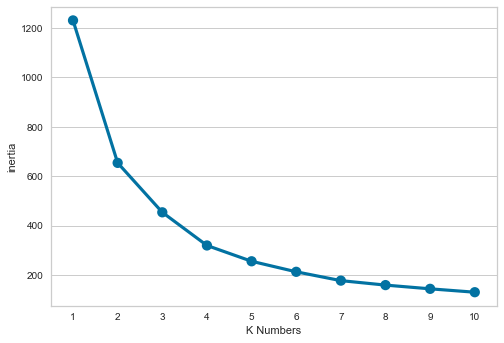

In [13]:
scaler = StandardScaler()
aggdf_scaled = scaler.fit_transform(agg_sales_df)
# transform into a dataframe
aggdf_scaled = pd.DataFrame(aggdf_scaled, index = agg_sales_df.index, columns = agg_sales_df.columns)

inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', max_iter= 300)
    kmeans.fit(aggdf_scaled)
    inertia[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('inertia')
plt.show()

In [14]:
clus = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 300,random_state=2)
clus.fit(aggdf_scaled)
# Assign the clusters to datamart
agg_sales_df['K_Cluster'] = clus.labels_
agg_sales_df.head()

,Total_Sales,Transaction_counts,Avg_quantity,K_Cluster
Point-of-Sale_ID,,,,
1,9.788721e+08,190532,3.198953,2
2,6.355667e+08,179922,2.170452,0
3,1.048183e+09,274866,2.190864,1
4,1.261483e+09,384966,2.072225,1
5,6.682029e+08,231739,1.825623,0


<AxesSubplot:xlabel='Total_Sales', ylabel='Avg_quantity'>

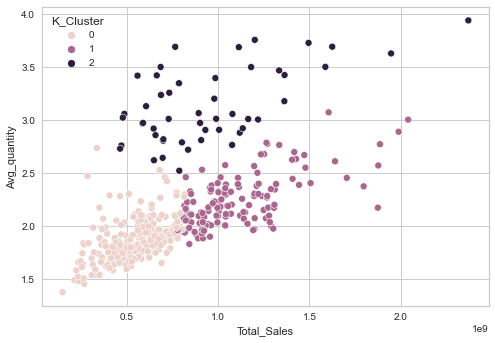

In [15]:
sns.scatterplot(x = "Total_Sales", y="Avg_quantity", hue="K_Cluster", data=agg_sales_df)

<AxesSubplot:xlabel='K_Cluster', ylabel='count'>

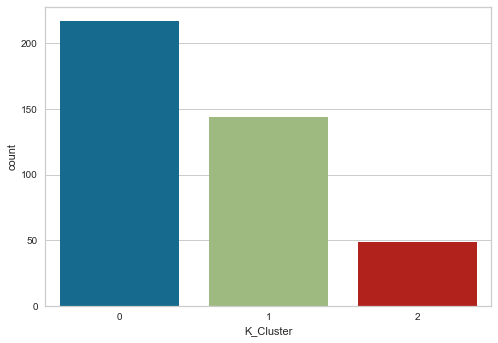

In [16]:
sns.countplot(x="K_Cluster",data=agg_sales_df)

## Cluster by family

In [6]:
df = pd.read_csv(path,dtype=dtype_dict,usecols = [1,6,8])

In [8]:
agg_family = df.groupby(['Point-of-Sale_ID','ProductFamily_ID']).count()

In [13]:
agg_family.to_csv(r'D:\NOVAIMS_MAA\agg_family.csv')

In [10]:
test_df = agg_family.reset_index()

In [11]:
pd.pivot_table(test_df, index='Point-of-Sale_ID', columns='ProductFamily_ID', 
                    aggfunc=lambda x: x if len(x)>0 else 0).fillna(0)

Quantity                                                     \
ProductFamily_ID        1    10    11     12    13    14     15    16      2   
Point-of-Sale_ID                                                               
1                   32521  2460   400  36866  1316  5861  12332  3082  10585   
2                   33522  1505   310  38003  1113  5536  12649  3360  10789   
3                   52154  1993   608  54799  1304  6464  18243  4588  15597   
4                   65636  4204  1308  86613  1928  7241  20797  4322  16497   
5                   37337  2224   626  49418  1328  5937  14301  3837  13248   
...                   ...   ...   ...    ...   ...   ...    ...   ...    ...   
406                 29412  1949   950  41827  1347  6054  12217  3952  12421   
407                 46084  2741   911  60080  1789  7291  17982  6355  15777   
408                 31711  1825   749  40929  1504  6614  14570  5250  10952   
409                 31439  1760   507  40321  1388  5861   9787  3457  11307   
410                 46210  3186  1194  60212  1915  7381  14793  6009  12138   

                       ...                                                   \
ProductFamily_ID   20  ...     7      9     3     8   17     18   19     21   
Point-of-Sale_ID       ...                                                    
1                 109  ...  1039  42789  2762  3809  196   8109  272  21910   
2                  80  ...  1129  41971  2392  3628   44   6254  143  14076   
3                  75  ...  1838  66417  3768  5086  130   9215  274  26277   
4                 428  ...  1598  86099  3713  5351  359  10470  507  61122   
5                 160  ...  1277  59854  3107  3786  180   8347  265  21742   
...               ...  ...   ...    ...   ...   ...  ...    ...  ...    ...   
406               320  ...   844  38695  2457  3704  126   7302  270  29033   
407               407  ...  1620  54901  3119  3866  190  10336  236  44369   
408                67  ...  1028  29514  2765  2786   39   9045  177  23265   
409               144  ...  1119  35637  2538  2853  110   8005  543  24224   
410               607  ...  1454  43727  2555  3459  141   9452  332  54612   

                             
ProductFamily_ID    4     5  
Point-of-Sale_ID             
1                 237  1512  
2                  88  1301  
3                 277  1725  
4                 224  1729  
5                 174  1640  
...               ...   ...  
406               188  1222  
407               477  1417  
408               478  1337  
409               329  1195  
410               447  1372  

[410 rows x 21 columns]